# Term Project

In [3]:
API_key = "6MW02P1D7JOI87BB" 
# 6MW02P1D7JOI87BB
# PLJNHLPBFWYM85RO
symbol = "NVDA"
size = "full"


In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import praw
import requests
# import time

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
# from sklearn.feature_extraction.text import TfidfVectorizer
# import torch

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# import yfinance as yf

In [5]:

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={API_key}&outputsize={size}'
r = requests.get(url)
data = r.json()

print(data)

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'NVDA', '3. Last Refreshed': '2025-04-02', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2025-04-02': {'1. open': '107.2900', '2. high': '111.9800', '3. low': '106.7900', '4. close': '110.4200', '5. volume': '220601243'}, '2025-04-01': {'1. open': '108.5150', '2. high': '110.2000', '3. low': '106.4700', '4. close': '110.1500', '5. volume': '222614034'}, '2025-03-31': {'1. open': '105.1300', '2. high': '110.9550', '3. low': '103.6500', '4. close': '108.3800', '5. volume': '299212653'}, '2025-03-28': {'1. open': '111.4850', '2. high': '112.8700', '3. low': '109.0701', '4. close': '109.6700', '5. volume': '229872549'}, '2025-03-27': {'1. open': '111.3500', '2. high': '114.4500', '3. low': '110.6600', '4. close': '111.4300', '5. volume': '236902055'}, '2025-03-26': {'1. open': '118.7300', '2. high': '118.8400', '3. low': '112.7100', '4. close': '113.76

In [6]:
# Storing results to df
df = pd.DataFrame(data['Time Series (Daily)']).transpose()

# Inspecting the result
df.info()

# Export to csv
df.to_csv("historial_records.csv")

<class 'pandas.core.frame.DataFrame'>
Index: 6394 entries, 2025-04-02 to 1999-11-01
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   1. open    6394 non-null   object
 1   2. high    6394 non-null   object
 2   3. low     6394 non-null   object
 3   4. close   6394 non-null   object
 4   5. volume  6394 non-null   object
dtypes: object(5)
memory usage: 299.7+ KB


## Feature Engineering

### Technical Indicators

Instead of calculating the technical indicators manually or using the TA library from Pandas, the caluculations were performed using Alpha Vantage. The decision is driven by the hope to maintain consistency within the workflow, as Alpha Vantage was already being used to fetch the historical daily stock dat. Enforcing the same source for both price data and technical indicators ensures uniformity in methodology and minimize discrepancies between datasets. 

The technical indicators include:

- Relative Strength Index (RSI)
- Money Flow Index (MFI)
- Bollinger Bands (BBAND)

In addition, intelligence such as sentiment analysis will also be used for model training. 



###  1) Relative Strength Index (RSI)

In [7]:
interval = "daily"
time_period = 50
series = "close"

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = f'https://www.alphavantage.co/query?function=RSI&symbol={symbol}&interval={interval}&time_period={time_period}&series_type={series}&apikey={API_key}'
r = requests.get(url)
rsi_data = r.json()

# Inspect data
print(data)

{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'NVDA', '3. Last Refreshed': '2025-04-02', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2025-04-02': {'1. open': '107.2900', '2. high': '111.9800', '3. low': '106.7900', '4. close': '110.4200', '5. volume': '220601243'}, '2025-04-01': {'1. open': '108.5150', '2. high': '110.2000', '3. low': '106.4700', '4. close': '110.1500', '5. volume': '222614034'}, '2025-03-31': {'1. open': '105.1300', '2. high': '110.9550', '3. low': '103.6500', '4. close': '108.3800', '5. volume': '299212653'}, '2025-03-28': {'1. open': '111.4850', '2. high': '112.8700', '3. low': '109.0701', '4. close': '109.6700', '5. volume': '229872549'}, '2025-03-27': {'1. open': '111.3500', '2. high': '114.4500', '3. low': '110.6600', '4. close': '111.4300', '5. volume': '236902055'}, '2025-03-26': {'1. open': '118.7300', '2. high': '118.8400', '3. low': '112.7100', '4. close': '113.76

In [8]:
# Storing indicator data into a df
df_rsi = pd.DataFrame(rsi_data)

# Storing rsi meta data
rsi_meta = df_rsi[["Meta Data"]].iloc[:7]

# Selecting rows with rsi values 
df_rsi = df_rsi[["Technical Analysis: RSI"]].iloc[7:]

# Inspect the meta data
rsi_meta

,Meta Data
1: Symbol,NVDA
2: Indicator,Relative Strength Index (RSI)
3: Last Refreshed,2025-04-02
4: Interval,daily
5: Time Period,50
6: Series Type,close
7: Time Zone,US/Eastern Time


In [9]:
# Create an array to store unpacked RSI values
rsi_values = []

# Unpacking the values from dictionaries
for dict in df_rsi["Technical Analysis: RSI"]:
    for key, value in dict.items():
        rsi_values.append(value)

# Store results in the df
df_rsi["RSI"] = rsi_values

# Merge df
result_df = pd.merge(df, df_rsi, left_index = True, right_index = True)

# Inspect df
result_df.head()

,1. open,2. high,3. low,4. close,5. volume,Technical Analysis: RSI,RSI
2025-04-02,107.2900,111.9800,106.7900,110.4200,220601243,{'RSI': '45.4922'},45.4922
2025-04-01,108.5150,110.2000,106.4700,110.1500,222614034,{'RSI': '45.4046'},45.4046
2025-03-31,105.1300,110.9550,103.6500,108.3800,299212653,{'RSI': '44.8354'},44.8354
2025-03-28,111.4850,112.8700,109.0701,109.6700,229872549,{'RSI': '45.1718'},45.1718
2025-03-27,111.3500,114.4500,110.6600,111.4300,236902055,{'RSI': '45.6296'},45.6296


### 2) Money Flow Index (MFI)
        

In [10]:

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = f'https://www.alphavantage.co/query?function=MFI&symbol={symbol}&interval={interval}&time_period={time_period}&apikey={API_key}'
r = requests.get(url)
mfi_data = r.json()

print(mfi_data)

{'Meta Data': {'1: Symbol': 'NVDA', '2: Indicator': 'Money Flow Index (MFI)', '3: Last Refreshed': '2025-04-02', '4: Interval': 'daily', '5: Time Period': 50, '6: Time Zone': 'US/Eastern Time'}, 'Technical Analysis: MFI': {'2025-04-02': {'MFI': '39.2741'}, '2025-04-01': {'MFI': '39.3915'}, '2025-03-31': {'MFI': '39.5048'}, '2025-03-28': {'MFI': '41.1729'}, '2025-03-27': {'MFI': '42.5779'}, '2025-03-26': {'MFI': '44.0443'}, '2025-03-25': {'MFI': '44.2191'}, '2025-03-24': {'MFI': '44.0158'}, '2025-03-21': {'MFI': '42.3690'}, '2025-03-20': {'MFI': '41.9108'}, '2025-03-19': {'MFI': '42.2385'}, '2025-03-18': {'MFI': '42.2565'}, '2025-03-17': {'MFI': '43.9325'}, '2025-03-14': {'MFI': '44.1665'}, '2025-03-13': {'MFI': '43.8418'}, '2025-03-12': {'MFI': '42.1798'}, '2025-03-11': {'MFI': '40.5691'}, '2025-03-10': {'MFI': '39.7570'}, '2025-03-07': {'MFI': '41.5055'}, '2025-03-06': {'MFI': '43.7953'}, '2025-03-05': {'MFI': '45.6122'}, '2025-03-04': {'MFI': '45.7147'}, '2025-03-03': {'MFI': '46.041

In [11]:
# Storing indicator data into a df
df_mfi = pd.DataFrame(mfi_data)

# Storing rsi meta data
mfi_meta = df_mfi[["Meta Data"]].iloc[:6]

# Selecting rows with rsi values 
df_mfi = df_mfi[["Technical Analysis: MFI"]].iloc[6:]

# Insepct the meta data
mfi_meta

,Meta Data
1: Symbol,NVDA
2: Indicator,Money Flow Index (MFI)
3: Last Refreshed,2025-04-02
4: Interval,daily
5: Time Period,50
6: Time Zone,US/Eastern Time


In [12]:
# Create an array to store unpacked RSI values
mfi_values = []

# Unpacking the values from dictionaries
for dict in df_mfi["Technical Analysis: MFI"]:
    for key, value in dict.items():
        mfi_values.append(value)

# Store results in the df
df_mfi["MFI"] = mfi_values

# Inspect df
df_mfi.head()

,Technical Analysis: MFI,MFI
2025-04-02,{'MFI': '39.2741'},39.2741
2025-04-01,{'MFI': '39.3915'},39.3915
2025-03-31,{'MFI': '39.5048'},39.5048
2025-03-28,{'MFI': '41.1729'},41.1729
2025-03-27,{'MFI': '42.5779'},42.5779


### 3) Bollinger Bands

In [13]:
# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = f'https://www.alphavantage.co/query?function=BBANDS&symbol={symbol}&interval={interval}&time_period={time_period}&series_type={series}&nbdevup=2&nbdevdn=2&apikey={API_key}'
r = requests.get(url)
bb_data = r.json()

print(bb_data)

{'Meta Data': {'1: Symbol': 'NVDA', '2: Indicator': 'Bollinger Bands (BBANDS)', '3: Last Refreshed': '2025-04-02', '4: Interval': 'daily', '5: Time Period': 50, '6.1: Deviation multiplier for upper band': 2, '6.2: Deviation multiplier for lower band': 2, '6.3: MA Type': 0, '7: Series Type': 'close', '8: Time Zone': 'US/Eastern Time'}, 'Technical Analysis: BBANDS': {'2025-04-02': {'Real Upper Band': '144.4526', 'Real Middle Band': '123.2613', 'Real Lower Band': '102.0701'}, '2025-04-01': {'Real Upper Band': '145.2949', 'Real Middle Band': '123.8693', 'Real Lower Band': '102.4437'}, '2025-03-31': {'Real Upper Band': '145.8231', 'Real Middle Band': '124.4203', 'Real Lower Band': '103.0174'}, '2025-03-28': {'Real Upper Band': '145.9753', 'Real Middle Band': '124.9238', 'Real Lower Band': '103.8723'}, '2025-03-27': {'Real Upper Band': '146.2792', 'Real Middle Band': '125.4550', 'Real Lower Band': '104.6308'}, '2025-03-26': {'Real Upper Band': '146.3655', 'Real Middle Band': '125.8614', 'Rea

In [14]:
# Storing indicator data into a df
df_bb = pd.DataFrame(bb_data)

# Storing rsi meta data
bb_meta = df_bb[["Meta Data"]].iloc[:10]

# Selecting rows with rsi values 
df_bb = df_bb[["Technical Analysis: BBANDS"]].iloc[10:]

# Meta data
bb_meta

,Meta Data
1: Symbol,NVDA
2: Indicator,Bollinger Bands (BBANDS)
3: Last Refreshed,2025-04-02
4: Interval,daily
5: Time Period,50
6.1: Deviation multiplier for upper band,2
6.2: Deviation multiplier for lower band,2
6.3: MA Type,0
7: Series Type,close
8: Time Zone,US/Eastern Time


In [15]:
# Create an array to store unpacked RSI values
upper_bb_values = []
SMA = []
bottom_bb_values = []

# Unpacking the values from dictionaries
for dict in df_bb["Technical Analysis: BBANDS"]:
    for key, value in dict.items():
        if key == "Real Upper Band":
            upper_bb_values.append(value)
        elif key == "Real Middle Band":
            SMA.append(value)
        else:
            bottom_bb_values.append(value)

# Store results in the df
df_bb["upper_bb_values"] = upper_bb_values
df_bb["SMA"] = SMA
df_bb["bottom_bb_values"] = bottom_bb_values

# Inspect df
df_bb.head()


,Technical Analysis: BBANDS,upper_bb_values,SMA,bottom_bb_values
2025-04-02,"{'Real Upper Band': '144.4526', 'Real Middle B...",144.4526,123.2613,102.0701
2025-04-01,"{'Real Upper Band': '145.2949', 'Real Middle B...",145.2949,123.8693,102.4437
2025-03-31,"{'Real Upper Band': '145.8231', 'Real Middle B...",145.8231,124.4203,103.0174
2025-03-28,"{'Real Upper Band': '145.9753', 'Real Middle B...",145.9753,124.9238,103.8723
2025-03-27,"{'Real Upper Band': '146.2792', 'Real Middle B...",146.2792,125.4550,104.6308


## Merge Dataframes 

Merging technical indicators with daily closing records

In [16]:
# Merge df
result_df = pd.merge(df, df_rsi, left_index = True, right_index = True)

In [17]:
# Merge df
result_df = pd.merge(df, df_mfi, left_index = True, right_index = True)

print(mfi_meta)
print(result_df.head())

                                Meta Data
1: Symbol                            NVDA
2: Indicator       Money Flow Index (MFI)
3: Last Refreshed              2025-04-02
4: Interval                         daily
5: Time Period                         50
6: Time Zone              US/Eastern Time
             1. open   2. high    3. low  4. close  5. volume  \
2025-04-02  107.2900  111.9800  106.7900  110.4200  220601243   
2025-04-01  108.5150  110.2000  106.4700  110.1500  222614034   
2025-03-31  105.1300  110.9550  103.6500  108.3800  299212653   
2025-03-28  111.4850  112.8700  109.0701  109.6700  229872549   
2025-03-27  111.3500  114.4500  110.6600  111.4300  236902055   

           Technical Analysis: MFI      MFI  
2025-04-02      {'MFI': '39.2741'}  39.2741  
2025-04-01      {'MFI': '39.3915'}  39.3915  
2025-03-31      {'MFI': '39.5048'}  39.5048  
2025-03-28      {'MFI': '41.1729'}  41.1729  
2025-03-27      {'MFI': '42.5779'}  42.5779  


# Sentiment analysis

In [68]:
import requests

# replace the "demo" apikey below with your own key from https://www.alphavantage.co/support/#api-key
url = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={symbol}&sort=RELEVANCE&limit=1000&apikey={API_key}'
r = requests.get(url)
data_SA = r.json()

print(data_SA)

{'items': '839', 'sentiment_score_definition': 'x <= -0.35: Bearish; -0.35 < x <= -0.15: Somewhat-Bearish; -0.15 < x < 0.15: Neutral; 0.15 <= x < 0.35: Somewhat_Bullish; x >= 0.35: Bullish', 'relevance_score_definition': '0 < x <= 1, with a higher score indicating higher relevance.', 'feed': [{'title': "Monday's Market Minute: A Busy Week On Wall Street", 'url': 'https://www.benzinga.com/news/earnings/22/05/27346302/mondays-market-minute-a-busy-week-on-wall-street', 'time_published': '20220523T131325', 'authors': ['TD Ameritrade Network'], 'summary': "This post contains sponsored advertising content. This content is for informational purposes only and not intended to be investing advice. Let's take a market minute to have a look at a few things you should be keeping an eye as we begin the trading week. First, headlines from the president are attr", 'banner_image': 'https://cdn.benzinga.com/files/images/story/2022/05/23/screenshot_2022-05-23_at_6.41.35_pm.png?width=1200&height=800&fit=c

In [69]:
# Storing data into a df
df_SA = pd.DataFrame(data_SA) 

# Empty array for appending
nvda_sentiments= []

# Unpacking the sentiment scores only relevant to the symbol
for article in df_SA["feed"]:
    ticker_list = article.get("ticker_sentiment", [])
    for ticker_data in ticker_list:
        if ticker_data.get("ticker") == symbol:
            nvda_sentiments.append({
                "time_published": article["time_published"],
                "sentiment_score": float(ticker_data["ticker_sentiment_score"]),
                "relevance_score": float(ticker_data["relevance_score"]),
                "label": ticker_data["ticker_sentiment_label"]
            })

# Inspect result
print(nvda_sentiments)

[{'time_published': '20220523T131325', 'sentiment_score': 0.07642, 'relevance_score': 1.0, 'label': 'Neutral'}, {'time_published': '20250227T220000', 'sentiment_score': 0.374189, 'relevance_score': 0.999998, 'label': 'Bullish'}, {'time_published': '20241121T220000', 'sentiment_score': 0.374189, 'relevance_score': 0.999998, 'label': 'Bullish'}, {'time_published': '20240829T210000', 'sentiment_score': 0.377878, 'relevance_score': 0.999982, 'label': 'Bullish'}, {'time_published': '20241004T141155', 'sentiment_score': 0.567232, 'relevance_score': 0.999957, 'label': 'Bullish'}, {'time_published': '20220602T171240', 'sentiment_score': 0.001259, 'relevance_score': 0.999868, 'label': 'Neutral'}, {'time_published': '20220328T195900', 'sentiment_score': 0.003124, 'relevance_score': 0.999833, 'label': 'Neutral'}, {'time_published': '20240905T121634', 'sentiment_score': 0.0, 'relevance_score': 0.999823, 'label': 'Neutral'}, {'time_published': '20220506T211100', 'sentiment_score': -0.223098, 'relev

In [97]:
# Storing into a df
df_SA = pd.DataFrame(nvda_sentiments)

# Create date column without the hourly info
df_SA["date"] = df_SA["time_published"].str[:8]

# Convert to dt
df_SA["date"] = pd.to_datetime(df_SA["date"], format = "%Y%m%d")

# Inspect DF
df_SA.tail()

,time_published,sentiment_score,relevance_score,label,date
834,20250219T142200,-0.004172,0.009846,Neutral,2025-02-19
835,20240501T021511,0.062677,0.009838,Neutral,2024-05-01
836,20240724T020019,0.112501,0.009818,Neutral,2024-07-24
837,20240808T050016,0.114229,0.009762,Neutral,2024-08-08
838,20250219T161500,0.034079,0.009634,Neutral,2025-02-19


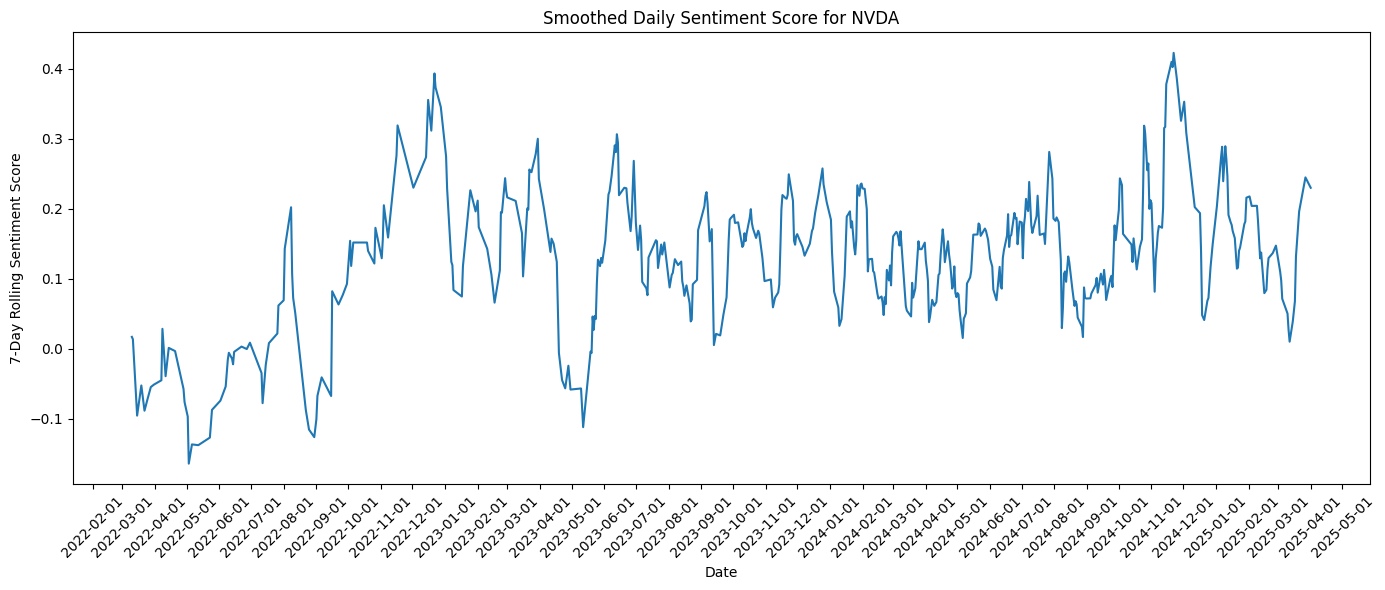

In [92]:
# Aggregate sentiment per day (average of multiple articles)
daily_sentiment = df_SA.groupby('date')['sentiment_score'].mean().reset_index()

# Apply 7-day rolling average to smooth it
daily_sentiment['rolling_sentiment'] = daily_sentiment['sentiment_score'].rolling(window=7, min_periods=1).mean()

# Plot
x = daily_sentiment['date']
y = daily_sentiment['rolling_sentiment']

plt.figure(figsize=(14, 6))
plt.plot(x, y, linestyle='-')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("7-Day Rolling Sentiment Score")
plt.title("Smoothed Daily Sentiment Score for NVDA")
plt.tight_layout()
plt.show()


In [101]:
daily_sentiment.head()

,date,sentiment_score,rolling_sentiment
0,2022-03-10,0.017037,0.017037
1,2022-03-11,0.010045,0.013541
2,2022-03-15,-0.313687,-0.095535
3,2022-03-19,0.076851,-0.052438
4,2022-03-22,-0.232915,-0.088534


## Reddit Scraping

In [ ]:
# Initiating praw
reddit = praw.Reddit(user_agent_= True,
                    client_id = 'qfeifpn8dnwFhvNF41GgQA',
                    client_secret = "4VHETeCdi7fCijNJSjUbzMzpyoPDhw",
                    user_agent = "windows:my_reddit_scraper:v1.0 (by /u/FewSecurity8323)",  # Throwaway account for scraping
)

# Selecting Subreddit
subreddit = reddit.subreddit("NVDA_Stock")

# Creating the list for storage
title = []
body = []
url = []

# Appending the array
for post in subreddit.hot(limit = 10):
    title.append(post.title),
    body.append(post.selftext),
    url.append(post.url)
    
# Creating a df to store scrapped data
df = pd.DataFrame({
    'title': title,
    'body': body,
    'url': url
})

# Saving the results to csv
df.to_csv('scrap_result.csv', index = False)
